<a href="https://colab.research.google.com/github/RgomezRo/capstone/blob/main/Time%20series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=87af30c351775080bceddf0bc604c36b0f0599542dc6c2d8bacc90ecbc826095
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
!pip install calmap

In [3]:

### importamos librerías

'''
instalar:
- plotly
- calmap
- folium
- wget
'''

#analisis
import pandas as pd 
import numpy as np
import sys
from scipy.stats import kurtosis, skew 
from scipy import stats
from google.colab import output
import datetime as dt

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)

#visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import calmap
import folium

#paletas
confirmados='#393e46'
fallecidos='#ff2e63'

import wget
import os
import json

# Data Loading

In [4]:

def read_FAO(fileName):
	import requests 
	file_url = "https://fenixservices.fao.org/faostat/static/bulkdownloads/"+fileName+".zip"
		
	r = requests.get(file_url, stream = True) 

	with open("temporalFile.zip", "wb") as file: 
		for block in r.iter_content(chunk_size = 1024): 
			if block: 
				file.write(block) 
		
	!unzip temporalFile.zip 

	Database = fileName + ".csv"	
	df = pd.read_csv(Database, encoding = "ISO-8859-1")

	return df




# Key differences between new and old Food Balance Sheet (FBS) methodology:

The key difference between the new and old food balances (FBS) methodologies is **the absence of a balancer variable.**

 In the past, one of the components of the FBS (often stocks, industrial
utilization or feed) would take on **the outstanding unbalanced mounts thus inheriting all the statistical errors.**

With the new methodology, the imputations for the FBS components (the data
of which are often not provided by countries) are **generated by dedicated modules; and a
balancing mechanism** will then proportionally spread the imbalances out among all the
components.

The most important output of the FBS is the Dietary Energy Supply (DES) in kilocalories per
person per day in a given country. This DES is based on the imputations generated by the
dedicated new food module. 

This module, in year t, is heavily influenced by food in year t-1,
and considering that the other variables in the module are changes in real GDP, population, and
commodity demand elasticity – all of which do not usually exhibit large variations from one
year to another - **the food quantities can be assumed to be comparable between the two methodologies.** 

However, the FBS balancing mechanism, in allocating all available quantities
to the food component for ‘food only’ commodities (e.g. meat of cattle), may result in
discrepancies with the old time series. Further analysis of this still needs to be carried out. 


In [5]:

### leer origenes

df_food_balances = read_FAO("FoodBalanceSheets_E_All_Data_(Normalized)")

df_emissions = read_FAO("Emissions_Totals_E_All_Data_(Normalized)")

df_food_transport = read_FAO("Environment_Transport_E_All_Data_(Normalized)")

df_waste_disposal = read_FAO("Emissions_Agriculture_Waste_Disposal_E_All_Data_(Normalized)")





Archive:  temporalFile.zip
  inflating: FoodBalanceSheets_E_All_Data_(Normalized).csv  
  inflating: FoodBalanceSheets_E_Flags.csv  
Archive:  temporalFile.zip
  inflating: Emissions_Totals_E_All_Data_(Normalized).csv  
  inflating: Emissions_Totals_E_Flags.csv  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  


Archive:  temporalFile.zip
  inflating: Environment_Transport_E_All_Data_(Normalized).csv  
 extracting: Environment_Transport_E_Flags.csv  
Archive:  temporalFile.zip
  inflating: Emissions_Agriculture_Waste_Disposal_E_All_Data_(Normalized).csv  
  inflating: Emissions_Agriculture_Waste_Disposal_E_Flags.csv  


In [6]:
df_food_balances["Year"] = pd.to_datetime(df_food_balances.Year, format='%Y')
df_emissions["Year"] = pd.to_datetime(df_emissions.Year, format='%Y')
df_food_transport["Year"] = pd.to_datetime(df_food_transport.Year, format='%Y')
df_waste_disposal["Year"] = pd.to_datetime(df_waste_disposal.Year, format='%Y')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
### lectura generada por pere
df_cluster_paises = pd.read_csv("/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/Cluster_Paises.csv", encoding = "ISO-8859-1")

In [9]:
def show_gaps_data(df_input):
  # create a smaller df

  df_input["MeasuredItem"]= df_input["Item"] + "-"+ df_input["Element"]

  # in order to show and fill na we aggregate a little bit the info

  df_input["area_measure_item"] = df_input["Area"] + "-"+ df_input["MeasuredItem"] 

  short_df = df_input[["Year", "Value","area_measure_item"]]


  # show  gaps in the data

  gb_df_ = short_df.pivot_table(index = ["Year"], columns = ['area_measure_item'], values = "Value", aggfunc = sum).isnull()
  #gb_df_= gb_df_.fillna(0)

  order_of_columns = list(gb_df_.sum().sort_values().index)
  
  gb_df_ = gb_df_[order_of_columns]


  plt.figure(figsize = (20, 10))
  plot = sns.heatmap(gb_df_, cbar = True, cmap = "inferno")
  plot.set_title("Null values in dataset");

  
  return df_input







In [10]:
def DataDesc(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
    
    return summary

In [11]:
def Null_Count(df):
    df_null = df.isnull().sum().sort_values(ascending = False).rename('Null').reset_index()

    null_count = df_null['Null']
    null_percent = (null_count * 100) / (df.shape[0])

    df_null = pd.concat([df_null['index'],null_count,null_percent], axis=1, keys=['Column','Null_Count','Null_Percent'])

    return df_null[df_null['Null_Count'] != 0]





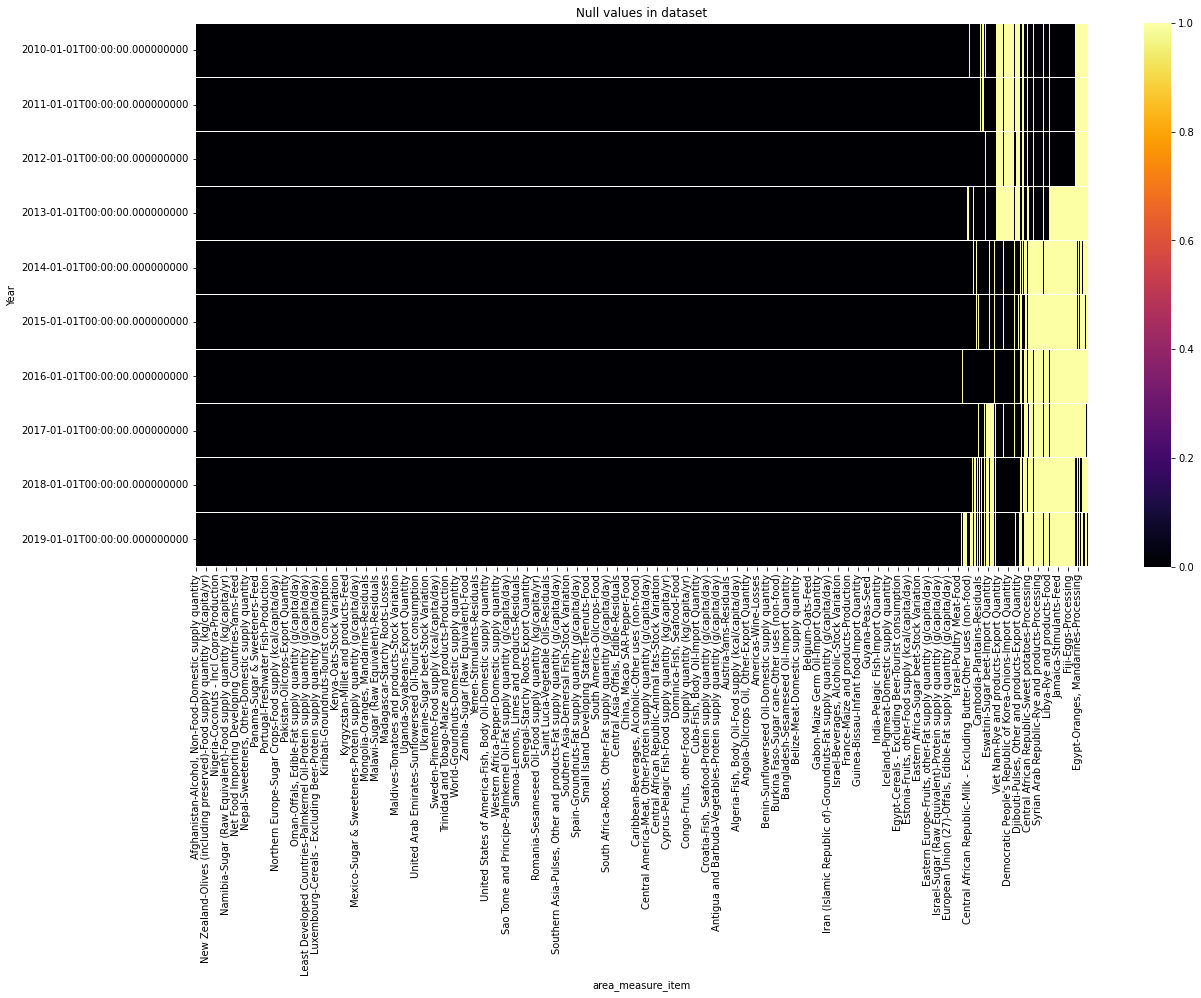

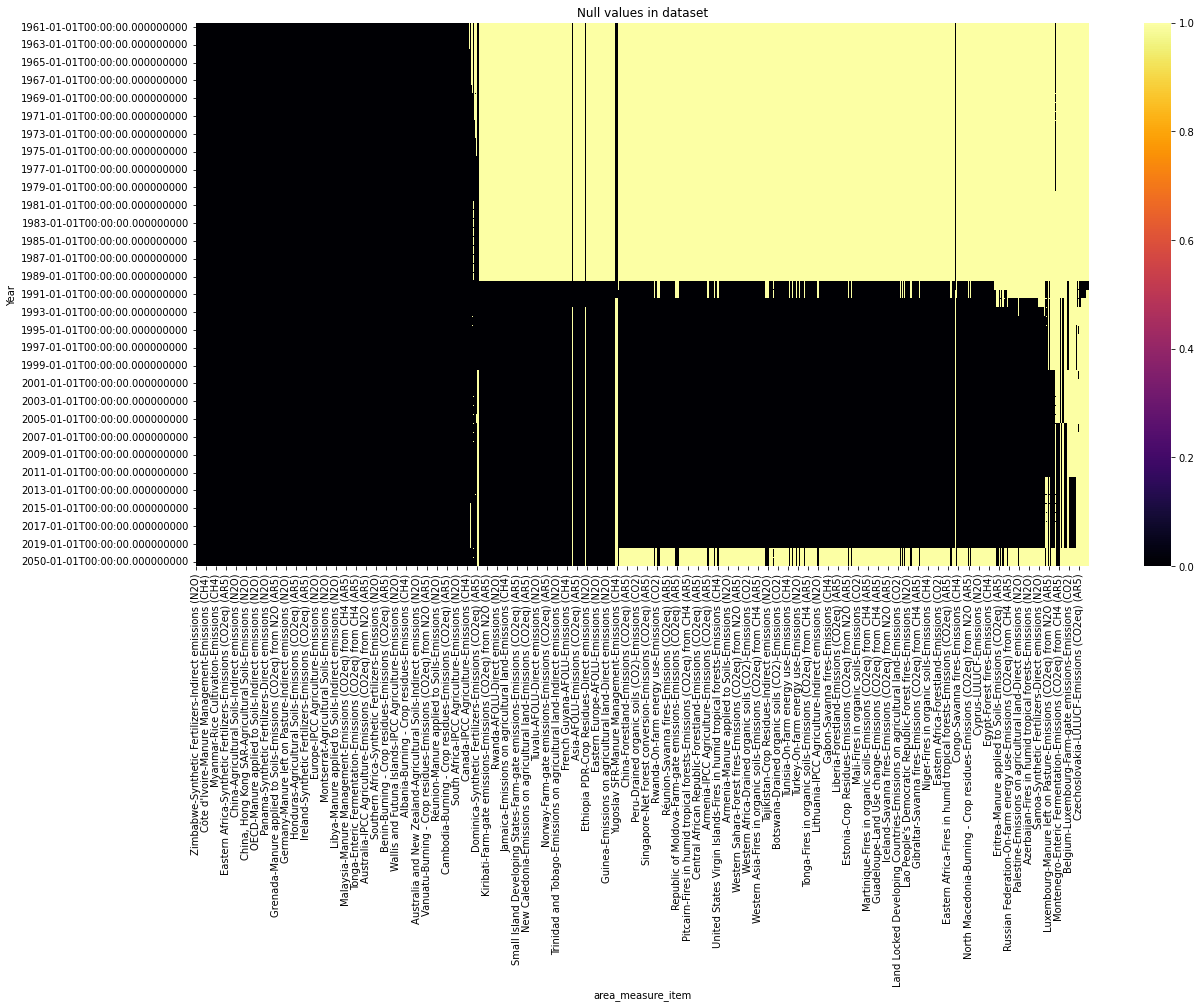

In [12]:
### mostrar donde se encuentran los gaps, tanto nulos como lineas inexistentes
df_food_balances = show_gaps_data(df_food_balances)
  
df_emissions = show_gaps_data(df_emissions)


In [13]:
DataDesc(df_food_balances)

### Vemos que tiene nulos y que hay que convertir a fecha el año

Dataset Shape: (2975297, 13)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Area Code,int64,0,216,2,2,2,7.73
1,Area,object,0,216,Afghanistan,Afghanistan,Afghanistan,7.73
2,Item Code,int64,0,123,2501,2501,2501,6.88
3,Item,object,0,120,Population,Population,Population,6.82
4,Element Code,int64,0,18,511,511,511,3.98
5,Element,object,0,18,Total Population - Both sexes,Total Population - Both sexes,Total Population - Both sexes,3.98
6,Year Code,int64,0,10,2010,2011,2012,3.32
7,Year,datetime64[ns],0,10,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00,3.32
8,Unit,object,0,5,1000 persons,1000 persons,1000 persons,1.37
9,Value,float64,63553,68992,29186.0,30117.0,31161.0,7.50


In [14]:
df_food_balances.groupby(["Element","Unit"]).count()

,,Area Code,Area,Item Code,Item,Element Code,Year Code,Year,Value,Flag,MeasuredItem,area_measure_item
Element,Unit,,,,,,,,,,,
Domestic supply quantity,1000 tonnes,247541,247541,247541,247541,247541,247541,247541,247541,247541,247541,247541
Export Quantity,1000 tonnes,204361,204361,204361,204361,204361,204361,204361,203224,204361,204361,204361
Fat supply quantity (g/capita/day),g/capita/day,232626,232626,232626,232626,232626,232626,232626,232626,232626,232626,232626
Feed,1000 tonnes,88461,88461,88461,88461,88461,88461,88461,78185,88461,88461,88461
Food,1000 tonnes,227822,227822,227822,227822,227822,227822,227822,227410,227822,227822,227822
Food supply (kcal/capita/day),kcal/capita/day,232318,232318,232318,232318,232318,232318,232318,232318,232318,232318,232318
Food supply quantity (kg/capita/yr),kg,227378,227378,227378,227378,227378,227378,227378,227378,227378,227378,227378
Import Quantity,1000 tonnes,236893,236893,236893,236893,236893,236893,236893,236702,236893,236893,236893
Losses,1000 tonnes,113402,113402,113402,113402,113402,113402,113402,108298,113402,113402,113402


In [15]:
DataDesc(df_emissions)
### Vemos que no tiene nulos y que hay que convertir a fecha el año

Dataset Shape: (1261741, 16)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Area Code,int64,0,280,2,2,2,8.04
1,Area,object,0,280,Afghanistan,Afghanistan,Afghanistan,8.04
2,Item Code,int64,0,25,5058,5058,5058,4.43
3,Item,object,0,25,Enteric Fermentation,Enteric Fermentation,Enteric Fermentation,4.43
4,Element Code,int64,0,8,7225,7225,7225,2.91
5,Element,object,0,8,Emissions (CH4),Emissions (CH4),Emissions (CH4),2.91
6,Year Code,int64,0,61,1961,1962,1963,5.73
7,Year,datetime64[ns],0,61,1961-01-01 00:00:00,1962-01-01 00:00:00,1963-01-01 00:00:00,5.73
8,Source Code,int64,0,2,3050,3050,3050,0.36
9,Source,object,0,2,FAO TIER 1,FAO TIER 1,FAO TIER 1,0.36


In [16]:
df_emissions.groupby(["Element","Item","Unit"]).count()

Area Code  \
Element                          Item                            Unit                    
Direct emissions (N2O)           AFOLU                           kilotonnes       7710   
                                 Agricultural Soils              kilotonnes      15506   
                                 Crop Residues                   kilotonnes      14366   
                                 Emissions on agricultural land  kilotonnes       7710   
                                 Farm-gate emissions             kilotonnes       7710   
                                 IPCC Agriculture                kilotonnes      14054   
                                 Manure applied to Soils         kilotonnes      14997   
                                 Manure left on Pasture          kilotonnes      14992   
                                 Synthetic Fertilizers           kilotonnes      12391   
Emissions (CH4)                  AFOLU                           kilotonnes       8401   
                                 Agricultural Soils              kilotonnes          9   
                                 Burning - Crop residues         kilotonnes      14271   
                                 Emissions on agricultural land  kilotonnes       8445   
                                 Enteric Fermentation            kilotonnes      15691   
                                 Farm-gate emissions             kilotonnes       8445   
                                 Fires in humid tropical forests kilotonnes       7915   
                                 Fires in organic soils          kilotonnes       7915   
                                 Forest fires                    kilotonnes       8144   
                                 IPCC Agriculture                kilotonnes      16928   
                                 LULUCF                          kilotonnes       9495   
                                 Land Use change                 kilotonnes       7915   
                                 Manure Management               kilotonnes      15691   
                                 On-farm energy use              kilotonnes       7568   
                                 Rice Cultivation                kilotonnes       9844   
                                 Savanna fires                   kilotonnes       8619   
Emissions (CO2)                  AFOLU                           kilotonnes       8035   
                                 Drained organic soils (CO2)     kilotonnes       4384   
                                 Emissions on agricultural land  kilotonnes       8049   
                                 Farm-gate emissions             kilotonnes       7623   
                                 Fires in organic soils          kilotonnes       7932   
                                 Forest fires                    kilotonnes         90   
                                 Forestland                      kilotonnes       8957   
                                 LULUCF                          kilotonnes      10043   
                                 Land Use change                 kilotonnes       8035   
                                 Net Forest conversion           kilotonnes       8872   
                                 On-farm energy use              kilotonnes       7568   
                                 Savanna fires                   kilotonnes        209   
Emissions (CO2eq) (AR5)          AFOLU                           kilotonnes       8525   
                                 Agricultural Soils              kilotonnes      16044   
                                 Burning - Crop residues         kilotonnes      14277   
                                 Crop Residues                   kilotonnes      14366   
                                 Drained organic soils           kilotonnes       5178   
                                 Drained organic soils (CO2)     kilotonnes       4384   
                           

In [17]:
DataDesc(df_cluster_paises)
### Vemos que el cluster tiene 3 divisiones

Dataset Shape: (205, 3)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Unnamed: 0,int64,0,205,0,1,2,7.68
1,Area,object,0,205,Afghanistan,Albania,Algeria,7.68
2,cluster,int64,0,3,1,1,1,1.31


In [18]:
df_cluster_paises.head(6)

# ejemplo de dos de ellas

,Unnamed: 0,Area,cluster
0,0,Afghanistan,1
1,1,Albania,1
2,2,Algeria,1
3,4,Angola,1
4,5,Anguilla,0
5,6,Antigua and Barbuda,0


In [19]:
def my_interp(x):
    if x.notnull().sum() > 1:
      return x.interpolate(method='nearest').ffill().bfill()
    else:
      if(x.isna().all()):
        return x.fillna(0)
      else:
        return x.ffill().bfill()

In [20]:
def generate_columns_for_dataset(old_df, columns_to_transpose,columns_to_transpose_by,column_with_value,pathToGenerateConfigFile):
  filtering_list = []
  df_filtered = old_df
  continue_with_old_config = "N"
  df_to_return = pd.DataFrame() 
  

  if(os.path.isfile(pathToGenerateConfigFile)):
    continue_with_old_config = input("\r\nYa existe un archivo con este nombre y esta ruta, pulse [Y] si desea recuperarlo:\r\n "   )
  
  

  if(continue_with_old_config=="Y"):
    with open(pathToGenerateConfigFile, "r") as read_file:
   
      df_to_return = pd.read_csv(pathToGenerateConfigFile, encoding = "ISO-8859-1")


  else:  
    for column_index in range(len(columns_to_transpose)): 

      current_column = columns_to_transpose[column_index]
      array_of_measured_items =  df_filtered.groupby(current_column).count().add_suffix("_count").reset_index()[current_column]
      
      output.clear()
      if(column_index != (len(columns_to_transpose)-1)):
        
        display(array_of_measured_items)
        value_to_filter = int(input("\r\nIntroduzca el índice de un [" + current_column + "] para filtrar:\r\n "   ))
        filtering_list.append(array_of_measured_items[value_to_filter])

      else:

        # this is the last type of row to transpose.
        decision = int(input(" \r\n Introduzca [1] si desea incluir todos los valores de ["+current_column + "]. \r\n Si prefiere filtrar los valores pulse [2]: \r\n" ))
        
        if(decision == 2):

          display(array_of_measured_items)
          value_to_filter = int(input("\r\nIntroduzca el índice de un [" + current_column + "] para filtrar:\r\n "   ))
          filtering_list.append(array_of_measured_items[value_to_filter])

          
      display(filtering_list)

      if(len(filtering_list)>0):

        for row_index in range(len(filtering_list)):

          row_to_filter = filtering_list[row_index]
          
          col = columns_to_transpose[row_index]
          df_filtered = df_filtered[df_filtered[col]==row_to_filter]
 
    columns_to_generate_prefix = "" 

    if(len(filtering_list)>0):
        for row_index in range(len(filtering_list)):
          row_to_filter = filtering_list[row_index]
          # we only filter if it is NOT the last column (this way we will be able to traspose it correctly)
          #><
          if(row_index < (len(columns_to_transpose)-1)):
            col = columns_to_transpose[row_index]
            df_filtered = df_filtered[df_filtered[col]==row_to_filter]
            columns_to_generate_prefix = (columns_to_generate_prefix + " " + row_to_filter).strip()

    
    last_granularity = columns_to_transpose[-1]
    columns_to_group_by = []
    columns_to_group_by.extend(columns_to_transpose_by)
    columns_to_group_by.append(last_granularity)

    gb_df= df_filtered.groupby(columns_to_group_by).sum().reset_index()
    df_to_return = df_filtered.groupby(columns_to_transpose_by).sum().reset_index()[columns_to_transpose_by]
    
    
    for last_level in gb_df[last_granularity].unique():
      
      column_name = columns_to_generate_prefix+ " " +last_level
      output.clear()
      display("Generating column "+ column_name)
      partial_df_to_merge = gb_df[gb_df[last_granularity]==last_level].copy()

      

      partial_df_to_merge[column_name] = partial_df_to_merge[column_with_value]

       #### INTERPOLATION FOR NULLS CALCULATION BASED ON AGRUPATIONS ALREADY DONE
      partial_df_to_merge[column_name] = partial_df_to_merge.groupby(columns_to_group_by)[column_name].apply(lambda x:my_interp(x))
      
      
      partial_df_to_merge.reset_index()



      list_column_to_use = []
      list_column_to_use.append(column_name)
      list_column_to_use.extend(columns_to_transpose_by) 
      
      partial_df_to_merge_cleaned = partial_df_to_merge[list_column_to_use].copy()
      df_to_return = pd.merge(df_to_return, partial_df_to_merge_cleaned, on = columns_to_transpose_by, how = "left")
  output.clear()
  
  if(continue_with_old_config!="Y"):
    df_to_return.to_csv(pathToGenerateConfigFile,index=False)
  
  display(df_to_return.head(3).T.head(10))    
  
  return df_to_return
    
  
  

    
        
      
    





In [22]:
path ="/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/transposicion_food.csv"

### if you dont have the file the order of input is 
###    -   n for the question 
###    -   [6] for selection of Element -- Food supply quantity (kg/capita/yr)
###    -   [1] [ALL ITEMS] for selection of Items   

feature_foods = generate_columns_for_dataset(df_food_balances,["Element","Item"],["Area","Year"],"Value",path)


,0,1,2
Area,Afghanistan,Afghanistan,Afghanistan
Year,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00
Food supply quantity (kg/capita/yr) Alcoholic Beverages,0.11,0.1,0.09
Food supply quantity (kg/capita/yr) Animal fats,1.41,1.41,1.43
Food supply quantity (kg/capita/yr) Apples and products,2.83,2.63,2.62
Food supply quantity (kg/capita/yr) Bananas,0.73,0.92,1.53
Food supply quantity (kg/capita/yr) Barley and products,1.09,1.85,1.3
Food supply quantity (kg/capita/yr) Beer,0.1,0.09,0.09
"Food supply quantity (kg/capita/yr) Beverages, Alcoholic",0.0,0.0,0.0
Food supply quantity (kg/capita/yr) Bovine Meat,4.58,4.66,4.3


In [23]:
### antes veíamos que food balances contenía nulos 

Null_Count(df_food_balances)

,Column,Null_Count,Null_Percent
0,Value,63553,2.136022


In [24]:
### veamos cuantos nulos contiene nuestro nuevo generado dataset,estos nulos corresponden a años para los que no aparece información
Null_Count(feature_foods).head(10)

,Column,Null_Count,Null_Percent
0,"Food supply quantity (kg/capita/yr) Alcohol, Non-Food",2092,98.031865
1,Food supply quantity (kg/capita/yr) Palm kernels,2072,97.094658
2,"Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals",2054,96.251172
3,Food supply quantity (kg/capita/yr) Cottonseed,2009,94.142455
4,Food supply quantity (kg/capita/yr) Sugar beet,1664,77.975633
5,Food supply quantity (kg/capita/yr) Sugar non-centrifugal,1626,76.194939
6,Food supply quantity (kg/capita/yr) Ricebran Oil,1410,66.073102
7,Food supply quantity (kg/capita/yr) Sorghum and products,1126,52.764761
8,Food supply quantity (kg/capita/yr) Millet and products,1106,51.827554
9,Food supply quantity (kg/capita/yr) Sugar cane,1016,47.610122


In [25]:
#### INTERPOLATION FOR NULLS CALCULATION BASED ON AGRUPATIONS ALREADY DONE
for column in feature_foods.columns[2:]:
  output.clear()
  display("Generating column "+column)
  feature_foods[column] = feature_foods.groupby("Area")[column].apply(lambda x:my_interp(x))
      

'Generating column Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals'

In [26]:
### veamos cuantos nulos contiene nuestro nuevo generado dataset
Null_Count(feature_foods).head(10)

,Column,Null_Count,Null_Percent


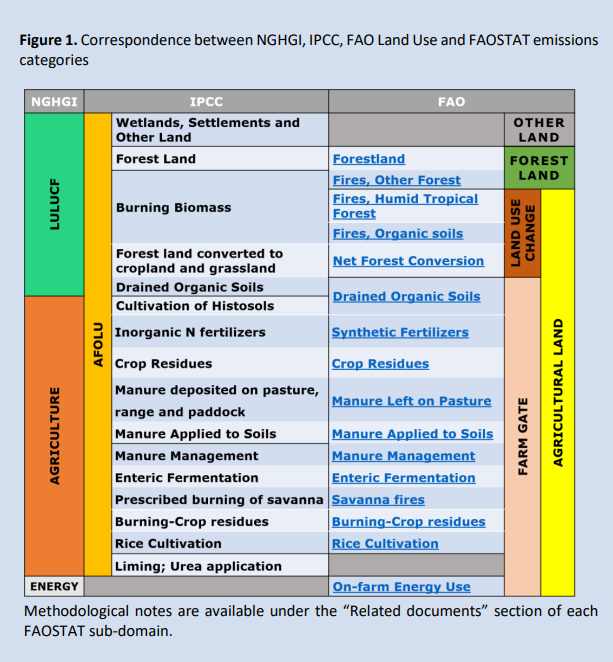



https://fenixservices.fao.org/faostat/static/documents/GT/GT_e.pdf

https://fenixservices.fao.org/faostat/static/documents/GT/Mapping_to_UNFCCC_IPCC.pdf



Los grupos que se observan en la imagen se encuentran tb en el dataset, tenemos que borrarlos.
Por otro lado existe un descuadre de 2 categorías de la imagen que corresponden a 4 items del dataset (Drained Organic Soils x2 y Forest Fires other = savanna fires + forest fires )

In [27]:
df_emissions.groupby(["Item","Item Code","Unit"]).sum().sort_values(by="Item Code")

,,,Area Code,Element Code,Year Code,Source Code,Value
Item,Item Code,Unit,,,,,
LULUCF,1707,kilotonnes,42977218,18939775973,110223362,167720658,3.559950e+08
Agricultural Soils,1709,kilotonnes,71379257,23569059446,157722349,241285007,1.105925e+09
IPCC Agriculture,1711,kilotonnes,99205521,37203688653,224834003,343934804,4.156873e+09
Enteric Fermentation,5058,kilotonnes,42740013,22809127629,93814539,143505516,2.041326e+09
Manure Management,5059,kilotonnes,71200365,34227525846,156001733,238635528,3.180264e+08
Rice Cultivation,5060,kilotonnes,38469234,14320568844,58855167,90074430,4.668202e+08
Synthetic Fertilizers,5061,kilotonnes,66622426,18194077598,120848626,184811052,3.089999e+08
Manure applied to Soils,5062,kilotonnes,70099791,22023256722,146932497,224820600,1.152355e+08
Manure left on Pasture,5063,kilotonnes,70146199,22015947272,146891933,224759580,4.499226e+08


In [28]:
array_aggregations = []
array_aggregations.append("LULUCF")
array_aggregations.append("Agricultural Soils")
array_aggregations.append("IPCC Agriculture")
array_aggregations.append("Land Use change")
array_aggregations.append("AFOLU")
array_aggregations.append("Emissions on agricultural land")
array_aggregations.append("Farm-gate emissions")

df_emissions= df_emissions.drop(df_emissions[df_emissions["Element"].isin(array_aggregations)].index)

In [29]:
# Una vez sacadas las agrupaciones podemos sumar la huella de carbono de cada pais y año
# sacando todos los datos de dióxido de carbono equivalente

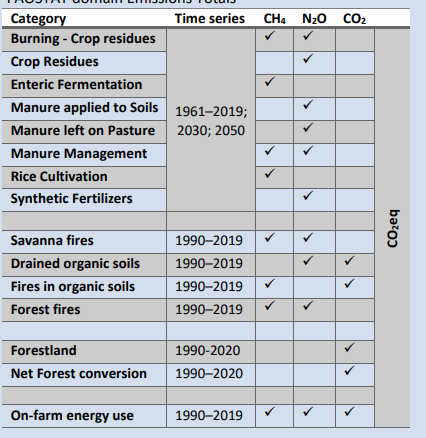

In [30]:
### Como vemos hay datos completos desde 1990. Al tener incompletos los años de 

In [31]:
path ="/content/drive/MyDrive/01. Data science/00. Proyecto Capstone/transposicion_emisiones_CO2_eq.csv"

### Si no tienes el archivo el orden de imputación es: 
###    -   n for the question
###    -   [2] All items for selection of [Element]
###    -   [3] Para la selección de las emisiones (CO2eq) 

feature_emissions_CO2_eq = generate_columns_for_dataset(df_emissions,["Element"],["Area","Year"],"Value",path)


,0,1,2
Area,Afghanistan,Afghanistan,Afghanistan
Year,1961-01-01 00:00:00,1962-01-01 00:00:00,1963-01-01 00:00:00
Emissions (CO2eq) (AR5),24215.6035,24417.6631,25181.3706


In [32]:
feature_emissions_CO2_eq.head(4 )

,Area,Year,Emissions (CO2eq) (AR5)
0,Afghanistan,1961-01-01,24215.6035
1,Afghanistan,1962-01-01,24417.6631
2,Afghanistan,1963-01-01,25181.3706
3,Afghanistan,1964-01-01,25628.0687


In [33]:
feature_emissions_CO2_eq.head(10)

,Area,Year,Emissions (CO2eq) (AR5)
0,Afghanistan,1961-01-01,24215.6035
1,Afghanistan,1962-01-01,24417.6631
2,Afghanistan,1963-01-01,25181.3706
3,Afghanistan,1964-01-01,25628.0687
4,Afghanistan,1965-01-01,26219.4802
5,Afghanistan,1966-01-01,27125.8129
6,Afghanistan,1967-01-01,27410.6202
7,Afghanistan,1968-01-01,28319.0168
8,Afghanistan,1969-01-01,28136.2565
9,Afghanistan,1970-01-01,28383.2813


In [95]:
### Before merging, in order to obtain a little bit more of data we would create a cartesian product
min_date=feature_foods["Year"].min()
display(min_date)
display(max_date)
max_date=feature_foods["Year"].max()
unique_areas = sorted(list(feature_foods["Area"].unique()))
date_range = pd.date_range(min_date, max_date, freq = "Y")
print("We have a total of {} years".format(len(date_range)))

cartesian_product = pd.MultiIndex.from_product([date_range,unique_areas], names = ["Year", "Area"])

Timestamp('2010-01-01 00:00:00')

Timestamp('2019-01-01 00:00:00')

We have a total of 9 years


In [96]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()
full_df["Year"] =  pd.to_datetime(df_food_balances["Year"].dt.year, format='%Y')
display(full_df.head())
full_df = pd.merge(full_df, feature_foods, on = ['Area','Year'], how = 'left')

full_df[full_df["Area"]== "Western Europe"].head()

,Year,Area
0,2010-01-01,Afghanistan
1,2011-01-01,Africa
2,2012-01-01,Albania
3,2013-01-01,Algeria
4,2014-01-01,Americas


,Year,Area,Food supply quantity (kg/capita/yr) Alcoholic Beverages,Food supply quantity (kg/capita/yr) Animal fats,Food supply quantity (kg/capita/yr) Apples and products,Food supply quantity (kg/capita/yr) Bananas,Food supply quantity (kg/capita/yr) Barley and products,Food supply quantity (kg/capita/yr) Beer,"Food supply quantity (kg/capita/yr) Beverages, Alcoholic",Food supply quantity (kg/capita/yr) Bovine Meat,...,"Food supply quantity (kg/capita/yr) Molluscs, Other",Food supply quantity (kg/capita/yr) Palm kernels,Food supply quantity (kg/capita/yr) Pelagic Fish,Food supply quantity (kg/capita/yr) Sugar beet,Food supply quantity (kg/capita/yr) Sugar non-centrifugal,Food supply quantity (kg/capita/yr) Sunflower seed,Food supply quantity (kg/capita/yr) Yams,"Food supply quantity (kg/capita/yr) Alcohol, Non-Food",Food supply quantity (kg/capita/yr) Cottonseed,"Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals"
209,2010-01-01,Western Europe,104.97,12.45,15.71,7.56,0.43,68.96,4.77,18.46,...,3.29,0.0,4.82,0.0,0.0,0.03,0.00,0.0,0.0,0.0
423,2017-01-01,Western Europe,103.96,13.05,14.92,9.82,0.92,68.11,4.45,16.92,...,2.31,0.0,4.66,0.0,0.0,0.01,0.03,0.0,0.0,0.0
637,2011-01-01,Western Europe,110.61,11.98,15.74,7.86,0.33,69.81,4.67,18.17,...,3.39,0.0,5.14,0.0,0.0,0.03,0.00,0.0,0.0,0.0
851,2011-01-01,Western Europe,110.61,11.98,15.74,7.86,0.33,69.81,4.67,18.17,...,3.39,0.0,5.14,0.0,0.0,0.03,0.00,0.0,0.0,0.0
1065,2013-01-01,Western Europe,102.63,12.22,17.29,8.28,0.39,64.64,6.06,17.78,...,2.71,0.0,4.68,0.0,0.0,0.04,0.04,0.0,0.0,0.0


In [97]:
### Mezclamos los dos datasets cogiendo de base el de food balances
display(full_df.head()) 
display(feature_emissions_CO2_eq.head())
                   


,Year,Area,Food supply quantity (kg/capita/yr) Alcoholic Beverages,Food supply quantity (kg/capita/yr) Animal fats,Food supply quantity (kg/capita/yr) Apples and products,Food supply quantity (kg/capita/yr) Bananas,Food supply quantity (kg/capita/yr) Barley and products,Food supply quantity (kg/capita/yr) Beer,"Food supply quantity (kg/capita/yr) Beverages, Alcoholic",Food supply quantity (kg/capita/yr) Bovine Meat,...,"Food supply quantity (kg/capita/yr) Molluscs, Other",Food supply quantity (kg/capita/yr) Palm kernels,Food supply quantity (kg/capita/yr) Pelagic Fish,Food supply quantity (kg/capita/yr) Sugar beet,Food supply quantity (kg/capita/yr) Sugar non-centrifugal,Food supply quantity (kg/capita/yr) Sunflower seed,Food supply quantity (kg/capita/yr) Yams,"Food supply quantity (kg/capita/yr) Alcohol, Non-Food",Food supply quantity (kg/capita/yr) Cottonseed,"Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals"
0,2010-01-01,Afghanistan,0.11,1.41,2.83,0.73,1.09,0.10,0.00,4.58,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0
1,2011-01-01,Africa,27.92,0.77,2.25,11.65,3.43,11.87,1.06,5.81,...,0.05,0.0,3.81,0.00,0.04,0.09,30.69,0.0,0.0,0.0
2,2012-01-01,Albania,34.23,3.48,24.48,5.22,1.00,26.50,1.43,14.70,...,0.31,0.0,3.34,0.00,0.00,0.00,0.00,0.0,0.0,0.0
3,2013-01-01,Algeria,3.71,0.80,13.80,6.47,15.48,3.27,0.14,5.26,...,0.02,0.0,2.55,0.00,0.00,0.00,0.00,0.0,0.0,0.0
4,2014-01-01,Americas,71.55,2.98,8.44,18.16,0.71,62.16,3.64,29.33,...,1.45,0.0,3.18,0.05,1.84,0.25,1.08,0.0,0.0,0.0


,Area,Year,Emissions (CO2eq) (AR5)
0,Afghanistan,1961-01-01,24215.6035
1,Afghanistan,1962-01-01,24417.6631
2,Afghanistan,1963-01-01,25181.3706
3,Afghanistan,1964-01-01,25628.0687
4,Afghanistan,1965-01-01,26219.4802


In [98]:
Null_Count(full_df).head(7)

,Column,Null_Count,Null_Percent
0,Food supply quantity (kg/capita/yr) Rice and products,5,0.259605
1,Food supply quantity (kg/capita/yr) Tea (including mate),5,0.259605
2,Food supply quantity (kg/capita/yr) Groundnuts,5,0.259605
3,Food supply quantity (kg/capita/yr) Cloves,5,0.259605
4,Food supply quantity (kg/capita/yr) Cassava and products,5,0.259605
5,"Food supply quantity (kg/capita/yr) Beverages, Fermented",5,0.259605
6,Food supply quantity (kg/capita/yr) Beans,5,0.259605


In [99]:
full_df[full_df["Food supply quantity (kg/capita/yr) Animal fats"].isna()].T.head(2)


,397,455,669,883,1097
Year,2011-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2011-01-01 00:00:00,2011-01-01 00:00:00
Area,Sudan,Burundi,Burundi,Burundi,Burundi


In [100]:
### sudan y burundi son los que tienen todos los valores a nulo, de hecho lo podemos comprobar fácilmente
display(Null_Count(full_df[~full_df["Area"].isin(["Sudan","Burundi"])]))

## intrapolamos el rellenado de nulos otra vez por area

#### INTERPOLATION FOR NULLS CALCULATION BASED ON AGRUPATIONS ALREADY DONE
for column in full_df.columns[2:]:
  output.clear()
  display("Generating column "+column)
  full_df[column] = full_df.groupby("Area")[column].apply(lambda x:my_interp(x))


'Generating column Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals'

In [78]:
Null_Count(full_df)

,Column,Null_Count,Null_Percent


In [101]:
df_with_target = pd.merge(full_df, feature_emissions_CO2_eq, on = ['Area','Year'], how = 'left')

In [102]:
Null_Count(df_with_target)

,Column,Null_Count,Null_Percent
0,Emissions (CO2eq) (AR5),1,0.051921


In [103]:
df_with_target[df_with_target[" Emissions (CO2eq) (AR5)"].isna()].T.head(2) 

,397
Year,2011-01-01 00:00:00
Area,Sudan


In [104]:
df_with_target[" Emissions (CO2eq) (AR5)"] = df_with_target.groupby("Area")[" Emissions (CO2eq) (AR5)"].apply(lambda x:my_interp(x))
df_with_target[df_with_target[" Emissions (CO2eq) (AR5)"].isna()].T.head(2) 

""
Year
Area


In [105]:
df_area_code = df_food_balances.groupby(["Area","Area Code"]).sum().reset_index()[["Area","Area Code"]]
df_with_target = pd.merge(df_with_target, df_area_code, on = ['Area'], how = 'left')
df_with_target.head(3).T

,0,1,2
Year,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00
Area,Afghanistan,Africa,Albania
Food supply quantity (kg/capita/yr) Alcoholic Beverages,0.11,27.92,34.23
Food supply quantity (kg/capita/yr) Animal fats,1.41,0.77,3.48
Food supply quantity (kg/capita/yr) Apples and products,2.83,2.25,24.48
Food supply quantity (kg/capita/yr) Bananas,0.73,11.65,5.22
Food supply quantity (kg/capita/yr) Barley and products,1.09,3.43,1.0
Food supply quantity (kg/capita/yr) Beer,0.1,11.87,26.5
"Food supply quantity (kg/capita/yr) Beverages, Alcoholic",0.0,1.06,1.43
Food supply quantity (kg/capita/yr) Bovine Meat,4.58,5.81,14.7


In [106]:
DataDesc(df_with_target)

Dataset Shape: (1926, 120)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Year,datetime64[ns],0,10,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00,3.32
1,Area,object,0,214,Afghanistan,Africa,Albania,7.74
2,Food supply quantity (kg/capita/yr) Alcoholic Beverages,float64,0,1013,0.11,27.92,34.23,9.72
3,Food supply quantity (kg/capita/yr) Animal fats,float64,0,571,1.41,0.77,3.48,8.74
4,Food supply quantity (kg/capita/yr) Apples and products,float64,0,720,2.83,2.25,24.48,9.01
5,Food supply quantity (kg/capita/yr) Bananas,float64,0,850,0.73,11.65,5.22,9.27
6,Food supply quantity (kg/capita/yr) Barley and products,float64,0,320,1.09,3.43,1.0,6.21
7,Food supply quantity (kg/capita/yr) Beer,float64,0,959,0.1,11.87,26.5,9.59
8,"Food supply quantity (kg/capita/yr) Beverages, Alcoholic",float64,0,544,0.0,1.06,1.43,8.40
9,Food supply quantity (kg/capita/yr) Bovine Meat,float64,0,862,4.58,5.81,14.7,9.46


In [122]:
df_with_target.rename(columns = {" Emissions (CO2eq) (AR5)":"Emissions CO2eq tonnes"}, inplace = True)


In [114]:
cols_to_drop = [

"Area"
    
]
df_with_target.drop(cols_to_drop, inplace = True, axis = 1)


KeyError: ignored

In [116]:
df_with_target.reset_index()

display(df_with_target.head())

,Year,Food supply quantity (kg/capita/yr) Alcoholic Beverages,Food supply quantity (kg/capita/yr) Animal fats,Food supply quantity (kg/capita/yr) Apples and products,Food supply quantity (kg/capita/yr) Bananas,Food supply quantity (kg/capita/yr) Barley and products,Food supply quantity (kg/capita/yr) Beer,"Food supply quantity (kg/capita/yr) Beverages, Alcoholic",Food supply quantity (kg/capita/yr) Bovine Meat,"Food supply quantity (kg/capita/yr) Butter, Ghee",...,Food supply quantity (kg/capita/yr) Pelagic Fish,Food supply quantity (kg/capita/yr) Sugar beet,Food supply quantity (kg/capita/yr) Sugar non-centrifugal,Food supply quantity (kg/capita/yr) Sunflower seed,Food supply quantity (kg/capita/yr) Yams,"Food supply quantity (kg/capita/yr) Alcohol, Non-Food",Food supply quantity (kg/capita/yr) Cottonseed,"Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals",Emissions (CO2eq) (AR5),Area Code
0,2010-01-01,0.11,1.41,2.83,0.73,1.09,0.10,0.00,4.58,1.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,8.862168e+04,2
1,2011-01-01,27.92,0.77,2.25,11.65,3.43,11.87,1.06,5.81,0.45,...,3.81,0.00,0.04,0.09,30.69,0.0,0.0,0.0,1.173763e+07,5100
2,2012-01-01,34.23,3.48,24.48,5.22,1.00,26.50,1.43,14.70,1.23,...,3.34,0.00,0.00,0.00,0.00,0.0,0.0,0.0,1.564863e+04,3
3,2013-01-01,3.71,0.80,13.80,6.47,15.48,3.27,0.14,5.26,0.55,...,2.55,0.00,0.00,0.00,0.00,0.0,0.0,0.0,6.442202e+04,4
4,2014-01-01,71.55,2.98,8.44,18.16,0.71,62.16,3.64,29.33,1.10,...,3.18,0.05,1.84,0.25,1.08,0.0,0.0,0.0,1.271520e+07,5200


In [123]:
# ------------------------------------------------------
# separate the dates for train, validation and test

train_index = sorted(list(df_with_target["Year"].unique()))[:-2]

valida_index = [sorted(list(df_with_target["Year"].unique()))[-2]]

test_index = [sorted(list(df_with_target["Year"].unique()))[-1]]

In [121]:
df_with_target.head()

,Year,Food supply quantity (kg/capita/yr) Alcoholic Beverages,Food supply quantity (kg/capita/yr) Animal fats,Food supply quantity (kg/capita/yr) Apples and products,Food supply quantity (kg/capita/yr) Bananas,Food supply quantity (kg/capita/yr) Barley and products,Food supply quantity (kg/capita/yr) Beer,"Food supply quantity (kg/capita/yr) Beverages, Alcoholic",Food supply quantity (kg/capita/yr) Bovine Meat,"Food supply quantity (kg/capita/yr) Butter, Ghee",...,Food supply quantity (kg/capita/yr) Pelagic Fish,Food supply quantity (kg/capita/yr) Sugar beet,Food supply quantity (kg/capita/yr) Sugar non-centrifugal,Food supply quantity (kg/capita/yr) Sunflower seed,Food supply quantity (kg/capita/yr) Yams,"Food supply quantity (kg/capita/yr) Alcohol, Non-Food",Food supply quantity (kg/capita/yr) Cottonseed,"Food supply quantity (kg/capita/yr) Meat, Aquatic Mammals",Emissions (CO2eq) (AR5),Area Code
0,2010-01-01,0.11,1.41,2.83,0.73,1.09,0.10,0.00,4.58,1.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,8.862168e+04,2
1,2011-01-01,27.92,0.77,2.25,11.65,3.43,11.87,1.06,5.81,0.45,...,3.81,0.00,0.04,0.09,30.69,0.0,0.0,0.0,1.173763e+07,5100
2,2012-01-01,34.23,3.48,24.48,5.22,1.00,26.50,1.43,14.70,1.23,...,3.34,0.00,0.00,0.00,0.00,0.0,0.0,0.0,1.564863e+04,3
3,2013-01-01,3.71,0.80,13.80,6.47,15.48,3.27,0.14,5.26,0.55,...,2.55,0.00,0.00,0.00,0.00,0.0,0.0,0.0,6.442202e+04,4
4,2014-01-01,71.55,2.98,8.44,18.16,0.71,62.16,3.64,29.33,1.10,...,3.18,0.05,1.84,0.25,1.08,0.0,0.0,0.0,1.271520e+07,5200


In [124]:
# ------------------------------------------------------
# split the data into train, validation and test dataset
# we "simulate" the test dataset to be the Kaggle test dataset

X_train = df_with_target[df_with_target["Year"].isin(train_index)].drop(['Emissions CO2eq tonnes', "Year"], axis=1)
Y_train = df_with_target[df_with_target["Year"].isin(train_index)]['Emissions CO2eq tonnes']

X_valida = df_with_target[df_with_target["Year"].isin(valida_index)].drop(['Emissions CO2eq tonnes', "Year"], axis=1)
Y_valida = df_with_target[df_with_target["Year"].isin(valida_index)]['Emissions CO2eq tonnes']

X_test = df_with_target[df_with_target["Year"].isin(test_index)].drop(['Emissions CO2eq tonnes', "Year"], axis = 1)
Y_test = df_with_target[df_with_target["Year"].isin(test_index)]['Emissions CO2eq tonnes']

In [130]:
import time
from string import punctuation

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import LabelEncoder

import itertools
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages


st = time.time()

model = XGBRegressor(seed = 175)

model_name = str(model).split("(")[0]

day = str(dt.datetime.now()).split()[0].replace("-", "_")
hour = str(dt.datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, eval_metric = "rmse", 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True, 
    early_stopping_rounds = 10)

et = time.time()

print("Training took {} minutes!".format((et - st)/60))

[02:53:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.85356e+06	validation_1-rmse:4.66627e+06
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:3.53225e+06	validation_1-rmse:4.27155e+06
[2]	validation_0-rmse:3.24041e+06	validation_1-rmse:3.90766e+06
[3]	validation_0-rmse:2.97632e+06	validation_1-rmse:3.56456e+06
[4]	validation_0-rmse:2.73616e+06	validation_1-rmse:3.25235e+06
[5]	validation_0-rmse:2.51983e+06	validation_1-rmse:2.98195e+06
[6]	validation_0-rmse:2.32497e+06	validation_1-rmse:2.75554e+06
[7]	validation_0-rmse:2.14368e+06	validation_1-rmse:2.52879e+06
[8]	validation_0-rmse:1.97758e+06	validation_1-rmse:2.32909e+06
[9]	validation_0-rmse:1.83274e+06	validation_1-rmse:2.18819e+06
[10]	validation_0-rmse:1.6884e+06	validation_1-rmse:2.01744e+06
[11]	valid

In [131]:
import pickle
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))

In [132]:
print("{}_{}.dat".format(model_name, t))

XGBRegressor_2022_03_27_02_53_00.dat


In [133]:
model = pickle.load(open("{}_{}.dat".format(model_name, t), "rb"))

[02:54:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


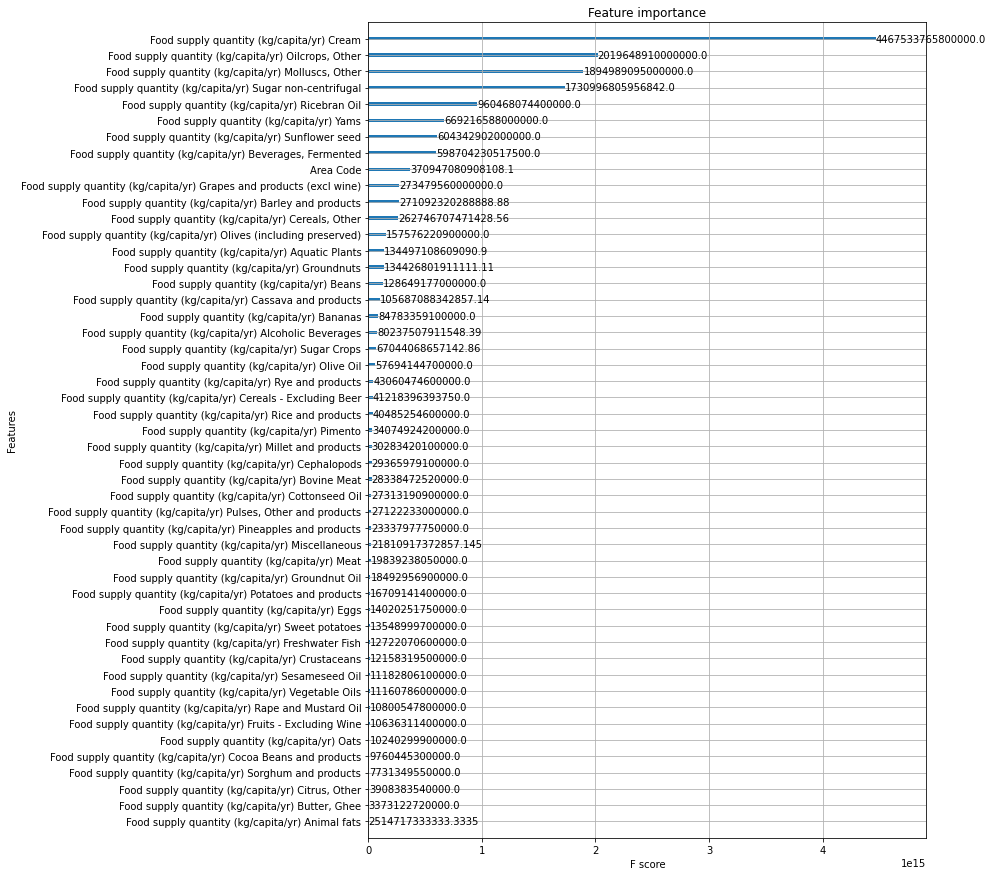

In [134]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
plot_importance(model, importance_type = "gain", ax = ax);

In [137]:
from sklearn import metrics
from math import sqrt
Y_valida_pred = model.predict(X_valida)

r2_valida = sqrt(metrics.r2_score(Y_valida, Y_valida_pred))
rmse_valida = sqrt(metrics.mean_squared_error(Y_valida, Y_valida_pred))
print("rmse",rmse_valida)
print("r2",r2_valida)

rmse 1182668.3356120016
r2 0.9715844915199157


In [139]:
### to dos : quitar valores negativos

### to dos : dividir emisiones per capita para dimensionarlos correctamente





-21091.842
151917.12
9633.249
6310027.5
57853.582


ValueError: ignored